In [1]:
#vårt projekt

from typing import Tuple

from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
from torch.utils.data import dataset
from torch.nn.utils.rnn import pad_sequence

import random
import numpy as np
import math

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# pip install sentencepiece
# pip install tqdm
#conda install pytorch torchvision torchaudio -c pytorch
#python -m pip uninstall pytorch

In [3]:
import sentencepiece as spm

In [4]:
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)

In [5]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
DEVICE = torch.device(device)
DEVICE


device(type='cpu')

In [6]:
#Alice paths
#data_path = '/Users/alicetottie/Downloads/projekt_data/train_paracrawl.en'
#data_path_2 = '/Users/alicetottie/Downloads/projekt_data/train_paracrawl.sv'

#Maja paths
# data_path = '/Users/majarygard/Documents/LTH/Projekt i Data/train_paracrawl.en'
# data_path_2 = '/Users/majarygard/Documents/LTH/Projekt i Data/train_paracrawl.sv'

#Pernilla paths
data_path = 'C:\\Users\\nilla\\Plugg\\project-data\\train_paracrawl.en\\train_paracrawl.en'
data_path_2 = 'C:\\Users\\nilla\\Plugg\\project-data\\train_paracrawl.sv\\train_paracrawl.sv'


In [7]:
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

with open(data_path_2, "r", encoding="utf-8") as f:
    lines2 = f.read().split("\n")    

In [8]:
len(lines)



4960283

In [9]:
len(lines2)

4960283

In [12]:
num_samples = 1000
input_texts = []
target_texts = []

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text= line.split("\t")
    input_texts.append(input_text)

with open("input_texts.txt", "w", encoding='utf-8') as f:
    for input_text in input_texts:
        f.write('\t'.join(input_text) + '\n')
    
for line in lines2[: min(num_samples, len(lines2) - 1)]:
    target_text= line.split("\t")
    target_texts.append(target_text)  

with open("target_texts.txt", "w", encoding='utf-8') as f:
    for target_text in target_texts:
        f.write('\t'.join(target_text) + '\n') 

In [13]:
input_texts[500]



['" This is my third course and I bought this concept a long time ago.']

In [14]:
target_texts[500]

['" Det här är min tredje kurs och jag har köpt det hela för länge sedan.']

In [15]:
TRAIN_PERCENTAGE = 0.8
train_val = int(TRAIN_PERCENTAGE * num_samples)
train_val

800

In [16]:
text_pairs = list(zip(input_texts, target_texts))
random.shuffle(text_pairs)
input_texts, target_texts = zip(*text_pairs)
input_texts, target_texts = list(input_texts), list(target_texts)


In [17]:
train_input_texts = input_texts[:train_val]
train_target_texts = target_texts[:train_val]

val_input_texts = input_texts[train_val:]
val_target_texts = target_texts[train_val:]

In [18]:
spm.SentencePieceTrainer.train('--input=input_texts.txt --model_prefix=m --vocab_size=2000 --model_type=bpe --pad_id=3')

# makes segmenter instance and loads the model file (m.model)
sp = spm.SentencePieceProcessor()
sp.load('m.model')

sp.SetEncodeExtraOptions("bos:eos")
sp.SetDecodeExtraOptions("bos:eos")

# encode: text => id
print(sp.encode_as_pieces('This is a test'))
print(sp.encode_as_ids('This is a test'))

# decode: id => text
print(sp.decode_pieces(['▁This', '▁is', '▁a', '▁t', 'est']))
print(sp.decode_ids([1, 665, 64, 5, 4, 134, 2]))

['<s>', '▁This', '▁is', '▁a', '▁t', 'est', '</s>']
[1, 665, 64, 5, 4, 134, 2]
This is a test
This is a test


In [19]:
def text2codes(texts, sp):
    codes = []
    for text in texts:
        text_l = text[0]
        code = sp.encode_as_ids(text_l)
        n_code = torch.tensor(code)
        codes.append(n_code)

    return codes



In [20]:
train_input_texts[:3], train_target_texts[:3]

([["!!TheM!Z!! hasn't added any friends yet!"],
  ['" Memory / Summerday" gouache/wood/butterfly 48x75 / 48x92cm 2006'],
  ['" child safety in Egypt "" harmfulness of the sun in Egypt on baby skin "" what medications the child in Egypt "" where on holiday with his family to Egypt "" pediatrician "" in which the child free hotels "']],
 [['!!TheM!Z!! har inte lagt till några vänner ännu!'],
  ['"Hågkomst / Sommardag" gouache/trä 48x75 /48x92cm2006'],
  ['" barnsäkerhet i Egypten "" skadlighet solen i Egypten på baby hud "" vilka mediciner barnet i Egypten "" där på semester med sin familj till Egypten "" barnläkare "" där barnet hotellsökningen "']])

In [21]:
text2codes(train_input_texts[:3], sp)[:3]

[tensor([   1,  314,  888, 1928, 1938, 1976,  460,  342, 1945, 1900, 1785,  242,
         1041,  304, 1938,    2]),
 tensor([   1,    8,   67,  171,  354,  464,   50,  130,  498,  894, 1911,   54,
           27,   71,    6, 1966, 1428, 1966,  891,  103, 1914,  108,  393, 1962,
         1951, 1957, 1943,  464,  393, 1962, 1951, 1582,  964,  341, 1956,    2]),
 tensor([   1,    8,  224,  396, 1260,  608,   34,  154,   78,   37,  414,  296,
          437,   23,    9, 1263,   34,  154,   89,   25, 1612, 1770,   78,  280,
         1792,  406,    9,  224,  396,   34,  154,   78,  709,   89, 1554,  111,
          246, 1824,   31,  154,   78,   36,   40, 1903,   17, 1636,  431,   78,
           34,  226,    9,  224,  396,   21,  434, 1036,    8,    2])]

In [22]:
def codes2text(codes):
    texts = []
    for code in codes:
        code_l = list(code)
        for p in code_l:
            texts.append(sp.id_to_piece(p.item()))
    return texts

In [23]:
codes2text(text2codes(train_input_texts[:3], sp)[:3])

['<s>',
 '▁!!',
 'The',
 'M',
 '!',
 'Z',
 '!!',
 '▁hasn',
 "'",
 't',
 '▁added',
 '▁any',
 '▁friends',
 '▁yet',
 '!',
 '</s>',
 '<s>',
 '▁"',
 '▁M',
 'em',
 'ory',
 '▁/',
 '▁S',
 'um',
 'mer',
 'day',
 '"',
 '▁g',
 'ou',
 'ac',
 'he',
 '/',
 'wood',
 '/',
 'but',
 'ter',
 'f',
 'ly',
 '▁4',
 '8',
 'x',
 '7',
 '5',
 '▁/',
 '▁4',
 '8',
 'x',
 '92',
 'cm',
 '▁200',
 '6',
 '</s>',
 '<s>',
 '▁"',
 '▁ch',
 'ild',
 '▁saf',
 'ety',
 '▁in',
 '▁Egypt',
 '▁""',
 '▁h',
 'arm',
 'ful',
 'ness',
 '▁of',
 '▁the',
 '▁sun',
 '▁in',
 '▁Egypt',
 '▁on',
 '▁b',
 'aby',
 '▁skin',
 '▁""',
 '▁what',
 '▁medic',
 'ations',
 '▁the',
 '▁ch',
 'ild',
 '▁in',
 '▁Egypt',
 '▁""',
 '▁where',
 '▁on',
 '▁holiday',
 '▁with',
 '▁his',
 '▁family',
 '▁to',
 '▁Egypt',
 '▁""',
 '▁p',
 'ed',
 'i',
 'at',
 'ric',
 'ian',
 '▁""',
 '▁in',
 '▁which',
 '▁the',
 '▁ch',
 'ild',
 '▁f',
 'ree',
 '▁hotels',
 '▁"',
 '</s>']

In [24]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super().__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)
                        * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)
        self.emb_size = emb_size

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding * math.sqrt(self.emb_size)
                            + self.pos_embedding[:token_embedding.size(0), :])

In [25]:
pe = PositionalEncoding(10, 0.1)

In [26]:
torch.zeros(1, 5, 10)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [27]:
pe(torch.zeros(1, 5, 10))

tensor([[[0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 1.1111],
         [0.0000, 0.0000, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 0.0000],
         [0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 1.1111],
         [0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 1.1111],
         [0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 1.1111]]])

In [28]:
# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super().__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)

        self.emb_size = emb_size
        # Same source and target embs Sect. 3.4
        self.embedding = nn.Embedding(
            vocab_size, emb_size, padding_idx=3)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)
        # Bias to be compatible with embeddings
        self.generator = nn.Linear(emb_size, vocab_size, bias=False)
        self.generator.weight = self.embedding.weight  # Shared weights Sect. 3.4

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.embedding(src))
        tgt_emb = self.positional_encoding(self.embedding(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
            self.embedding(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
            self.embedding(tgt)), memory,
            tgt_mask)


In [29]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float(
        '-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [30]:
generate_square_subsequent_mask(10)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [31]:
def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),
                           device=DEVICE).type(torch.bool)

    src_padding_mask = (src == 3).transpose(0, 1)
    tgt_padding_mask = (tgt == 3).transpose(0, 1).type(torch.float32)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask


In [32]:
src = pad_sequence(text2codes(
    train_input_texts[:3], sp), padding_value=3)
tgt = pad_sequence(text2codes(
    train_target_texts[:3], sp), padding_value=3)

In [33]:
train_input_texts[:3], train_target_texts[:3]

([["!!TheM!Z!! hasn't added any friends yet!"],
  ['" Memory / Summerday" gouache/wood/butterfly 48x75 / 48x92cm 2006'],
  ['" child safety in Egypt "" harmfulness of the sun in Egypt on baby skin "" what medications the child in Egypt "" where on holiday with his family to Egypt "" pediatrician "" in which the child free hotels "']],
 [['!!TheM!Z!! har inte lagt till några vänner ännu!'],
  ['"Hågkomst / Sommardag" gouache/trä 48x75 /48x92cm2006'],
  ['" barnsäkerhet i Egypten "" skadlighet solen i Egypten på baby hud "" vilka mediciner barnet i Egypten "" där på semester med sin familj till Egypten "" barnläkare "" där barnet hotellsökningen "']])

In [34]:
create_mask(src, tgt)

(tensor([[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]),
 tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
         [0., 0., -inf,  ..., -inf, -inf, -inf],
         [0., 0., 0.,  ..., -inf, -inf, -inf],
         ...,
         [0., 0., 0.,  ..., 0., -inf, -inf],
         [0., 0., 0.,  ..., 0., 0., -inf],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  

In [35]:
VOCAB_SIZE = 2000 #max(token2idx.values()) + 1  # or len(token2idx)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3


In [36]:
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=3)

optimizer = torch.optim.Adam(
    transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

C:\Users\nilla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [37]:
from torch.utils.data import Dataset, DataLoader

In [38]:
class PairDataset(Dataset):
    def __init__(self, input_texts, target_texts, token2idx):
        self.input_texts = input_texts
        self.target_texts = target_texts
        self.token2idx = token2idx

    def __len__(self):
        return len(self.input_texts)

    def __getitem__(self, idx):
        src_batch = text2codes([input_texts[idx]], self.token2idx)
        tgt_batch = text2codes([target_texts[idx]], self.token2idx)

        return src_batch[0], tgt_batch[0]

    def collate(self, batch):
        src_batch, tgt_batch = list(zip(*batch))
        src_batch = pad_sequence(src_batch, padding_value=3)
        tgt_batch = pad_sequence(tgt_batch, padding_value=3)

        return src_batch, tgt_batch

In [39]:
train_dataset = PairDataset(train_input_texts, train_target_texts, sp)
train_dataloader = DataLoader(train_dataset, batch_size=32,
                              shuffle=True, collate_fn=train_dataset.collate)

In [40]:
val_dataset = PairDataset(val_input_texts, val_target_texts, sp)
val_dataloader = DataLoader(
    val_dataset, batch_size=32, collate_fn=val_dataset.collate)

In [41]:
def train_epoch(model, optimizer, dataloader):
    model.train()
    losses = 0
    sent_cnt = 0
    correct, total = 0, 0
    for src_batch, tgt_batch in tqdm(dataloader):
        src = src_batch.to(DEVICE)
        tgt = tgt_batch.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(
            src, tgt_input)

        logits = model(src,
                       tgt_input,
                       src_mask,
                       tgt_mask,
                       src_padding_mask,
                       tgt_padding_mask,
                       src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(
            logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

        with torch.no_grad():
            sent_cnt += tgt_out.size()[-1]

            total += torch.numel(tgt_input)
            _, char_pred = torch.max(logits, -1)
            correct += (char_pred == tgt_out).sum().item()

    return losses / sent_cnt, correct / total


In [42]:
def evaluate(model, dataloader):
    model.eval()
    losses = 0
    sent_cnt = 0
    correct, total = 0, 0

    for src_batch, tgt_batch in dataloader:
        src = src_batch.to(DEVICE)
        tgt = tgt_batch.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(
            src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,
                       src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(
            logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()
        sent_cnt += tgt_out.size()[-1]

        total += torch.numel(tgt_input)
        _, char_pred = torch.max(logits, -1)
        correct += (char_pred == tgt_out).sum().item()

    return losses / sent_cnt, correct / total


In [46]:
from timeit import default_timer as timer
NUM_EPOCHS = 15
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = timer()
    train_loss, train_acc = train_epoch(
        transformer, optimizer, train_dataloader)
    train_losses += [train_loss]
    train_accs += [train_acc]
    end_time = timer()
    val_loss, val_acc = evaluate(transformer, val_dataloader)
    val_losses += [val_loss]
    val_accs += [val_acc]
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, Train acc.: {train_acc:.3f}, Val acc.: {val_acc:.3f}, Epoch time = {(end_time - start_time):.3f}s"))


100%|██████████| 25/25 [00:55<00:00,  2.23s/it]


Epoch: 1, Train loss: 0.172, Val loss: 0.186, Train acc.: 0.013, Val acc.: 0.016, Epoch time = 55.657s


100%|██████████| 25/25 [01:00<00:00,  2.42s/it]


Epoch: 2, Train loss: 0.167, Val loss: 0.178, Train acc.: 0.021, Val acc.: 0.028, Epoch time = 60.584s


100%|██████████| 25/25 [01:04<00:00,  2.60s/it]


Epoch: 3, Train loss: 0.160, Val loss: 0.171, Train acc.: 0.030, Val acc.: 0.035, Epoch time = 64.959s


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Epoch: 4, Train loss: 0.154, Val loss: 0.164, Train acc.: 0.035, Val acc.: 0.044, Epoch time = 65.544s


100%|██████████| 25/25 [01:00<00:00,  2.41s/it]


Epoch: 5, Train loss: 0.149, Val loss: 0.158, Train acc.: 0.042, Val acc.: 0.050, Epoch time = 60.255s


100%|██████████| 25/25 [01:04<00:00,  2.57s/it]


Epoch: 6, Train loss: 0.144, Val loss: 0.151, Train acc.: 0.047, Val acc.: 0.055, Epoch time = 64.196s


100%|██████████| 25/25 [01:04<00:00,  2.58s/it]


Epoch: 7, Train loss: 0.139, Val loss: 0.146, Train acc.: 0.049, Val acc.: 0.059, Epoch time = 64.538s


100%|██████████| 25/25 [01:03<00:00,  2.52s/it]


Epoch: 8, Train loss: 0.135, Val loss: 0.142, Train acc.: 0.054, Val acc.: 0.061, Epoch time = 63.049s


100%|██████████| 25/25 [01:04<00:00,  2.58s/it]


Epoch: 9, Train loss: 0.131, Val loss: 0.138, Train acc.: 0.056, Val acc.: 0.067, Epoch time = 64.554s


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Epoch: 10, Train loss: 0.128, Val loss: 0.133, Train acc.: 0.058, Val acc.: 0.070, Epoch time = 65.562s


100%|██████████| 25/25 [01:02<00:00,  2.50s/it]


Epoch: 11, Train loss: 0.125, Val loss: 0.129, Train acc.: 0.062, Val acc.: 0.074, Epoch time = 62.488s


100%|██████████| 25/25 [01:02<00:00,  2.49s/it]


Epoch: 12, Train loss: 0.122, Val loss: 0.126, Train acc.: 0.065, Val acc.: 0.076, Epoch time = 62.253s


100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


Epoch: 13, Train loss: 0.120, Val loss: 0.123, Train acc.: 0.069, Val acc.: 0.079, Epoch time = 59.682s


100%|██████████| 25/25 [01:00<00:00,  2.44s/it]


Epoch: 14, Train loss: 0.117, Val loss: 0.120, Train acc.: 0.071, Val acc.: 0.082, Epoch time = 61.001s


100%|██████████| 25/25 [00:59<00:00,  2.36s/it]


Epoch: 15, Train loss: 0.115, Val loss: 0.117, Train acc.: 0.073, Val acc.: 0.084, Epoch time = 59.100s


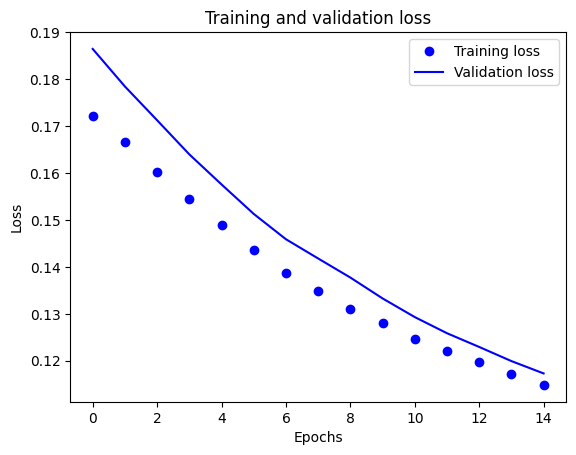

In [47]:
epochs = range(NUM_EPOCHS)

plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

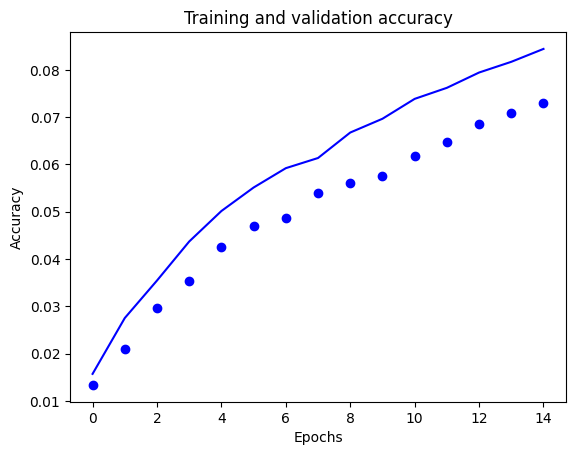

In [48]:
plt.plot(epochs, train_accs, 'bo', label='Training acc')
plt.plot(epochs, val_accs, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [49]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    # print(ys)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        # print(ys) # Remove the comment to understand the loop
        if next_word == 2:
            break
    return ys


In [57]:
text2codes(['Go!'], sp)[0].view(-1, 1)

tensor([[  1],
        [128],
        [  2]])

In [93]:
# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text2codes([src_sentence], sp)[0].view(-1, 1)
    print("SRC: ", src)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model, src, src_mask, max_len=num_tokens + 20, start_symbol=1).flatten()
    print("Targ: ", tgt_tokens)
    tgt_chars_specials = codes2text([tgt_tokens])
    tgt_chars = []
    for char in tgt_chars_specials:
        if char != '<s>' and char != '<\s>':
            tgt_chars += [char]
    tgt_chars = ''.join(tgt_chars)
    return tgt_chars


In [94]:
tgt_sent = translate(transformer, 'I drink water every day')
tgt_sent

SRC:  tensor([[ 1],
        [47],
        [ 2]])
Targ:  tensor([  1,   8, 129, 144, 254, 144, 254, 144, 254, 144, 254, 144, 254, 144,
        254, 144, 254, 144, 254, 144,   2])


'▁"▁Jag▁jag▁jag▁jag▁jag▁jag▁jag▁jag▁jag</s>'

In [80]:
tgt = translate(transformer, "The house at the end of my street is red")
tgt

SRC:  tensor([[ 1],
        [56],
        [ 2]])
Targ:  tensor([   1,    8, 1933, 1904, 1904, 1904,    2])


'▁"Ennn</s>'

In [73]:
print(sp.decode_ids([  1,   8, 129, 144, 254, 144, 254, 144, 254, 144, 254, 144, 254, 144,
        254, 144, 254, 144, 254, 144,   2]))

" Jag jag jag jag jag jag jag jag jag
